<a href="https://colab.research.google.com/github/elisabethelen/UAS06DL-2025/blob/main/RestNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path dataset awal (yang berisi folder daun)
source_dir = '/content/drive/MyDrive/DatasetFloraGroup'

# Path output dataset setelah split
output_base = '/content/drive/MyDrive/DatasetFloraSplit'

Mounted at /content/drive


In [ ]:
source_dir = '/content/drive/MyDrive/DatasetFloraGroup '  # ← sesuai hasil yang muncul

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (224, 224)
batch_size = 32

# Direktori data
train_dir = '/content/drive/MyDrive/DatasetFloraSplit/train'
val_dir = '/content/drive/MyDrive/DatasetFloraSplit/val'

# Augmentasi dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generator data latih dengan shuffle ON
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True        # ✅ penting untuk memastikan data acak per epoch
)

# Generator data validasi tanpa shuffle
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False       # ✅ biarkan urut untuk evaluasi stabil
)

# Jumlah kelas dari data
num_classes = len(train_data.class_indices)

# Label kelas
class_labels = list(train_data.class_indices.keys())

Found 529 images belonging to 8 classes.
Found 137 images belonging to 8 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, Input, Model # Added Sequential, Input, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam # Added Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Added EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense # Added CNN layers

**TRAINNING MODEL RESTNET50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle, os

# ── 1. Bangun model ResNet50 (tanpa top) + klasifikasi custom
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_resnet.trainable = False  # freeze pretrained weights

resnet_model = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

resnet_model.compile(optimizer=Adam(0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# ── 2. Path penyimpanan
model_path   = '/content/drive/MyDrive/models/resnet_daun_12kelas.h5'
history_path = '/content/drive/MyDrive/models/resnet_daun_12kelas_history.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# ── 3. Callback untuk simpan model terbaik
checkpoint = ModelCheckpoint(model_path, monitor='val_loss',
                             save_best_only=True, verbose=1)

# ── 4. Training
resnet_history = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

# ── 5. Simpan history training
with open(history_path, 'wb') as f:
    pickle.dump(resnet_history.history, f)

print(f'Model terbaik disimpan di: {model_path}')
print(f'History   disimpan di: {history_path}')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.0661 - loss: 2.3502 
Epoch 1: val_loss improved from inf to 1.95756, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - accuracy: 0.0699 - loss: 2.3419 - val_accuracy: 0.2117 - val_loss: 1.9576
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2041 - loss: 1.9079
Epoch 2: val_loss improved from 1.95756 to 1.87158, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 10s/step - accuracy: 0.2031 - loss: 1.9069 - val_accuracy: 0.2263 - val_loss: 1.8716
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2382 - loss: 1.8380
Epoch 3: val_loss improved from 1.87158 to 1.84797, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 203s 10s/step - accuracy: 0.2361 - loss: 1.8384 - val_accuracy: 0.2482 - val_loss: 1.8480
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2220 - loss: 1.8311
Epoch 4: val_loss improved from 1.84797 to 1.83483, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.2222 - loss: 1.8307 - val_accuracy: 0.2263 - val_loss: 1.8348
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1990 - loss: 1.8110
Epoch 5: val_loss improved from 1.83483 to 1.82423, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 212s 10s/step - accuracy: 0.1996 - loss: 1.8112 - val_accuracy: 0.2263 - val_loss: 1.8242
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2449 - loss: 1.8180
Epoch 6: val_loss improved from 1.82423 to 1.81396, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.2452 - loss: 1.8173 - val_accuracy: 0.2555 - val_loss: 1.8140
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2351 - loss: 1.8060
Epoch 7: val_loss improved from 1.81396 to 1.80425, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step - accuracy: 0.2343 - loss: 1.8058 - val_accuracy: 0.2409 - val_loss: 1.8043
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2548 - loss: 1.8209
Epoch 8: val_loss improved from 1.80425 to 1.79629, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.2536 - loss: 1.8194 - val_accuracy: 0.2774 - val_loss: 1.7963
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2462 - loss: 1.7483
Epoch 9: val_loss improved from 1.79629 to 1.79035, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.2471 - loss: 1.7503 - val_accuracy: 0.2701 - val_loss: 1.7904
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2463 - loss: 1.7869
Epoch 10: val_loss improved from 1.79035 to 1.77813, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.2469 - loss: 1.7865 - val_accuracy: 0.2336 - val_loss: 1.7781
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2646 - loss: 1.7639
Epoch 11: val_loss improved from 1.77813 to 1.77113, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 217s 11s/step - accuracy: 0.2631 - loss: 1.7646 - val_accuracy: 0.2774 - val_loss: 1.7711
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3148 - loss: 1.7418
Epoch 12: val_loss improved from 1.77113 to 1.76429, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 173s 10s/step - accuracy: 0.3131 - loss: 1.7432 - val_accuracy: 0.2993 - val_loss: 1.7643
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2682 - loss: 1.7432
Epoch 13: val_loss improved from 1.76429 to 1.75445, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.2672 - loss: 1.7442 - val_accuracy: 0.2701 - val_loss: 1.7545
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2401 - loss: 1.7564
Epoch 14: val_loss improved from 1.75445 to 1.74742, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 210s 10s/step - accuracy: 0.2414 - loss: 1.7565 - val_accuracy: 0.2920 - val_loss: 1.7474
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2472 - loss: 1.7633
Epoch 15: val_loss improved from 1.74742 to 1.74192, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.2490 - loss: 1.7629 - val_accuracy: 0.3066 - val_loss: 1.7419
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2529 - loss: 1.7489
Epoch 16: val_loss improved from 1.74192 to 1.73348, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 204s 10s/step - accuracy: 0.2539 - loss: 1.7484 - val_accuracy: 0.3358 - val_loss: 1.7335
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2891 - loss: 1.7342
Epoch 17: val_loss improved from 1.73348 to 1.72695, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 214s 10s/step - accuracy: 0.2877 - loss: 1.7345 - val_accuracy: 0.3431 - val_loss: 1.7270
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2588 - loss: 1.7639
Epoch 18: val_loss improved from 1.72695 to 1.71941, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 166s 10s/step - accuracy: 0.2608 - loss: 1.7623 - val_accuracy: 0.3577 - val_loss: 1.7194
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2978 - loss: 1.7375
Epoch 19: val_loss improved from 1.71941 to 1.71262, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 165s 10s/step - accuracy: 0.2969 - loss: 1.7368 - val_accuracy: 0.3504 - val_loss: 1.7126
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3186 - loss: 1.7187
Epoch 20: val_loss improved from 1.71262 to 1.70631, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.3179 - loss: 1.7187 - val_accuracy: 0.3504 - val_loss: 1.7063
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3302 - loss: 1.7086
Epoch 21: val_loss improved from 1.70631 to 1.69774, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 10s/step - accuracy: 0.3296 - loss: 1.7089 - val_accuracy: 0.3723 - val_loss: 1.6977
Epoch 22/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3434 - loss: 1.6823
Epoch 22: val_loss improved from 1.69774 to 1.69185, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - accuracy: 0.3425 - loss: 1.6840 - val_accuracy: 0.3796 - val_loss: 1.6918
Epoch 23/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3444 - loss: 1.7047
Epoch 23: val_loss improved from 1.69185 to 1.68532, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.3425 - loss: 1.7052 - val_accuracy: 0.3650 - val_loss: 1.6853
Epoch 24/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3426 - loss: 1.6914
Epoch 24: val_loss improved from 1.68532 to 1.68053, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 10s/step - accuracy: 0.3426 - loss: 1.6918 - val_accuracy: 0.3869 - val_loss: 1.6805
Epoch 25/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3396 - loss: 1.6776
Epoch 25: val_loss improved from 1.68053 to 1.67682, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.3380 - loss: 1.6788 - val_accuracy: 0.3942 - val_loss: 1.6768
Epoch 26/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3667 - loss: 1.6795
Epoch 26: val_loss improved from 1.67682 to 1.66872, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.3639 - loss: 1.6800 - val_accuracy: 0.3285 - val_loss: 1.6687
Epoch 27/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2965 - loss: 1.6718
Epoch 27: val_loss improved from 1.66872 to 1.66488, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 208s 10s/step - accuracy: 0.2968 - loss: 1.6728 - val_accuracy: 0.3650 - val_loss: 1.6649
Epoch 28/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2983 - loss: 1.7178
Epoch 28: val_loss improved from 1.66488 to 1.65560, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.2985 - loss: 1.7160 - val_accuracy: 0.3650 - val_loss: 1.6556
Epoch 29/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3469 - loss: 1.6761
Epoch 29: val_loss improved from 1.65560 to 1.65553, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 167s 10s/step - accuracy: 0.3466 - loss: 1.6760 - val_accuracy: 0.3796 - val_loss: 1.6555
Epoch 30/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3798 - loss: 1.6542
Epoch 30: val_loss improved from 1.65553 to 1.65004, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - accuracy: 0.3775 - loss: 1.6552 - val_accuracy: 0.4015 - val_loss: 1.6500
Epoch 31/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3575 - loss: 1.6679
Epoch 31: val_loss improved from 1.65004 to 1.64331, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 10s/step - accuracy: 0.3566 - loss: 1.6678 - val_accuracy: 0.3723 - val_loss: 1.6433
Epoch 32/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3003 - loss: 1.6714
Epoch 32: val_loss improved from 1.64331 to 1.63809, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.3012 - loss: 1.6713 - val_accuracy: 0.4015 - val_loss: 1.6381
Epoch 33/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3689 - loss: 1.6495
Epoch 33: val_loss improved from 1.63809 to 1.63487, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.3683 - loss: 1.6501 - val_accuracy: 0.3796 - val_loss: 1.6349
Epoch 34/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2964 - loss: 1.7221
Epoch 34: val_loss improved from 1.63487 to 1.63067, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 206s 10s/step - accuracy: 0.2985 - loss: 1.7189 - val_accuracy: 0.3942 - val_loss: 1.6307
Epoch 35/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3467 - loss: 1.6091
Epoch 35: val_loss improved from 1.63067 to 1.62452, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - accuracy: 0.3451 - loss: 1.6113 - val_accuracy: 0.4015 - val_loss: 1.6245
Epoch 36/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3012 - loss: 1.6375
Epoch 36: val_loss did not improve from 1.62452
17/17 ━━━━━━━━━━━━━━━━━━━━ 203s 9s/step - accuracy: 0.3020 - loss: 1.6383 - val_accuracy: 0.3650 - val_loss: 1.6246
Epoch 37/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3748 - loss: 1.6145
Epoch 37: val_loss improved from 1.62452 to 1.61366, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 178s 10s/step - accuracy: 0.3738 - loss: 1.6161 - val_accuracy: 0.3869 - val_loss: 1.6137
Epoch 38/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3499 - loss: 1.6494
Epoch 38: val_loss did not improve from 1.61366
17/17 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.3495 - loss: 1.6491 - val_accuracy: 0.3723 - val_loss: 1.6156
Epoch 39/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3670 - loss: 1.6186
Epoch 39: val_loss improved from 1.61366 to 1.60439, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.3681 - loss: 1.6193 - val_accuracy: 0.4015 - val_loss: 1.6044
Epoch 40/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3708 - loss: 1.6254
Epoch 40: val_loss improved from 1.60439 to 1.60321, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - accuracy: 0.3721 - loss: 1.6257 - val_accuracy: 0.4015 - val_loss: 1.6032
Epoch 41/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3168 - loss: 1.6336
Epoch 41: val_loss improved from 1.60321 to 1.59873, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.3173 - loss: 1.6336 - val_accuracy: 0.3723 - val_loss: 1.5987
Epoch 42/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3566 - loss: 1.6554
Epoch 42: val_loss did not improve from 1.59873
17/17 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.3571 - loss: 1.6538 - val_accuracy: 0.3723 - val_loss: 1.5988
Epoch 43/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4369 - loss: 1.6130
Epoch 43: val_loss improved from 1.59873 to 1.58917, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.4341 - loss: 1.6133 - val_accuracy: 0.4015 - val_loss: 1.5892
Epoch 44/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3723 - loss: 1.5999
Epoch 44: val_loss improved from 1.58917 to 1.58671, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - accuracy: 0.3703 - loss: 1.6004 - val_accuracy: 0.3942 - val_loss: 1.5867
Epoch 45/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4056 - loss: 1.6030
Epoch 45: val_loss did not improve from 1.58671
17/17 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step - accuracy: 0.4053 - loss: 1.6033 - val_accuracy: 0.3650 - val_loss: 1.5897
Epoch 46/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3660 - loss: 1.6112
Epoch 46: val_loss improved from 1.58671 to 1.57831, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 10s/step - accuracy: 0.3651 - loss: 1.6111 - val_accuracy: 0.3723 - val_loss: 1.5783
Epoch 47/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4207 - loss: 1.5539
Epoch 47: val_loss improved from 1.57831 to 1.57771, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - accuracy: 0.4194 - loss: 1.5566 - val_accuracy: 0.3796 - val_loss: 1.5777
Epoch 48/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3946 - loss: 1.5881
Epoch 48: val_loss improved from 1.57771 to 1.57428, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 174s 10s/step - accuracy: 0.3935 - loss: 1.5889 - val_accuracy: 0.3796 - val_loss: 1.5743
Epoch 49/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3732 - loss: 1.5899
Epoch 49: val_loss improved from 1.57428 to 1.56982, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - accuracy: 0.3714 - loss: 1.5910 - val_accuracy: 0.4015 - val_loss: 1.5698
Epoch 50/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3994 - loss: 1.5601
Epoch 50: val_loss improved from 1.56982 to 1.56323, saving model to /content/drive/MyDrive/models/resnet_daun_12kelas.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 165s 10s/step - accuracy: 0.3981 - loss: 1.5618 - val_accuracy: 0.3942 - val_loss: 1.5632
Model terbaik disimpan di: /content/drive/MyDrive/models/resnet_daun_12kelas.h5
History   disimpan di: /content/drive/MyDrive/models/resnet_daun_12kelas_history.pkl


**EVALUASI MODEL RESTNET50**

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.3974 - loss: 1.5970
Test loss  : 1.5632
Test acc   : 0.3942

Classification Report:
               precision    recall  f1-score   support

Daun Singkong       0.54      1.00      0.70        14
   Daun Sirih       0.00      0.00      0.00         7
DaunBelimbing       0.00      0.00      0.00         9
    DaunJambu       0.18      0.13      0.15        30
    DaunJeruk       0.00      0.00      0.00         1
   DaunMangga       0.43      0.83      0.56        29
   DaunNangka       0.28      0.26      0.27        27
    DaunSalam       0.62      0.25      0.36        20

     accuracy                           0.39       137
    macro avg       0.26      0.31      0.26       137
 weighted avg       0.33      0.39      0.33       137



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


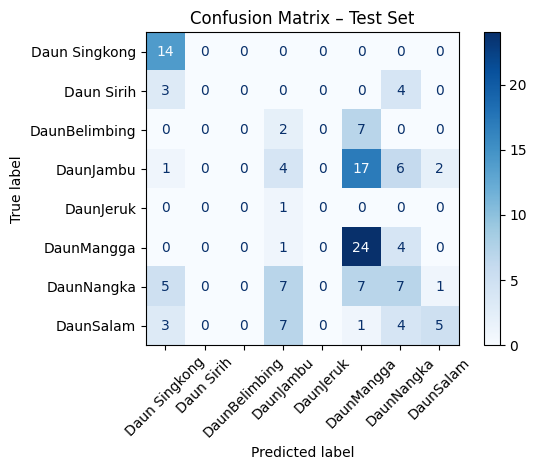

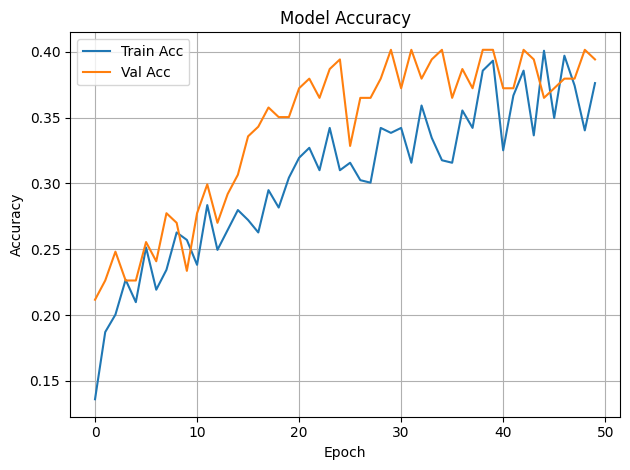

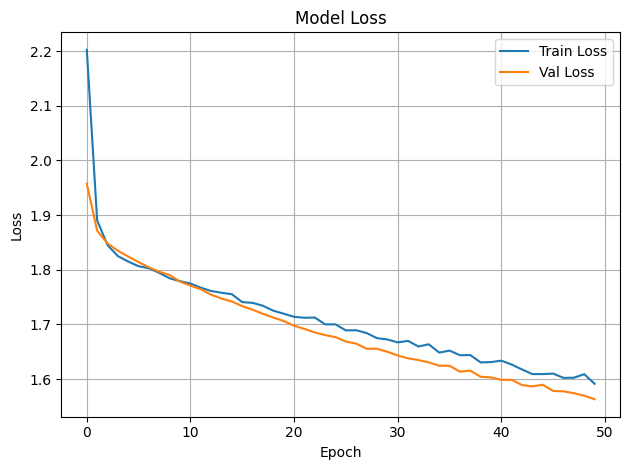

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

# 1️⃣ ── Muat model terbaik dari ResNet
best_model = tf.keras.models.load_model('/content/drive/MyDrive/models/resnet_daun_12kelas.h5')

# 2️⃣ ── Evaluasi cepat
test_loss, test_acc = best_model.evaluate(val_data)
print(f"Test loss  : {test_loss:.4f}")
print(f"Test acc   : {test_acc:.4f}")

# 3️⃣ ── Prediksi label
y_true        = val_data.classes
y_pred_probs  = best_model.predict(val_data, verbose=0)
y_pred        = np.argmax(y_pred_probs, axis=1)

# 4️⃣ ── Classification report
class_names = list(val_data.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5️⃣ ── Confusion Matrix
cm   = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

# 6️⃣ ── Plot history dari file .pkl
with open('/content/drive/MyDrive/models/resnet_daun_12kelas_history.pkl', 'rb') as f:
    history = pickle.load(f)

plt.figure()
plt.plot(history['accuracy'],     label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Model Accuracy'); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(history['loss'],     label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Model Loss'); plt.grid(True)
plt.tight_layout(); plt.show()


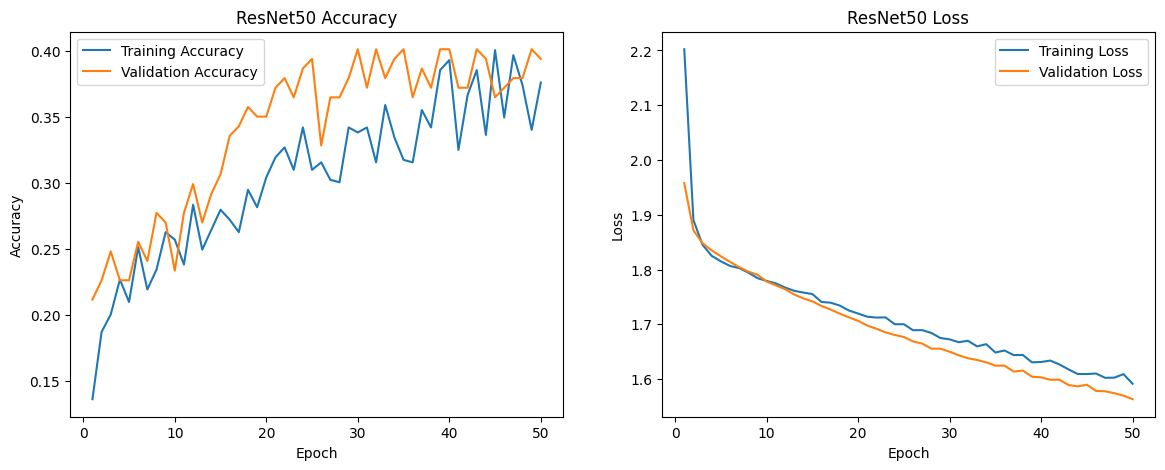

In [ ]:
import matplotlib.pyplot as plt
import pickle # Import pickle to load the history

def plot_training_history(history, model_name):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Plot Akurasi
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Load the history from the pickle file
history_path = '/content/drive/MyDrive/models/resnet_daun_12kelas_history.pkl'
with open(history_path, 'rb') as f:
    resnet_history = pickle.load(f)

# Call the function with the correct history variable
plot_training_history(resnet_history, 'ResNet50')